# **Q-Learning Blackjack**

In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np
from tqdm import tqdm

In [2]:
class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool], mode: str = "train") -> int:
        if mode == "train":
            if np.random.random() < self.epsilon:
                return self.env.action_space.sample()
            else:
                return int(np.argmax(self.q_values[obs]))
        elif mode == "test":
            if obs in self.q_values:
                return int(np.argmax(self.q_values[obs]))
            else:
                return self.env.action_space.sample()

    def update(
            self,
            obs: tuple[int, int, bool],
            action: int,
            reward: float,
            terminated: bool,
            next_obs: tuple[int, int, bool]
    ):
            future_q_value = (not terminated) * np.max(self.q_values[next_obs])
            temporal_difference = (
                reward + self.discount_factor * future_q_value - self.q_values[obs][action]
            )

            self.q_values[obs][action] = (
                self.q_values[obs][action] + self.lr * temporal_difference
            )
            self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [3]:
# Hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)


for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 22892.75it/s]


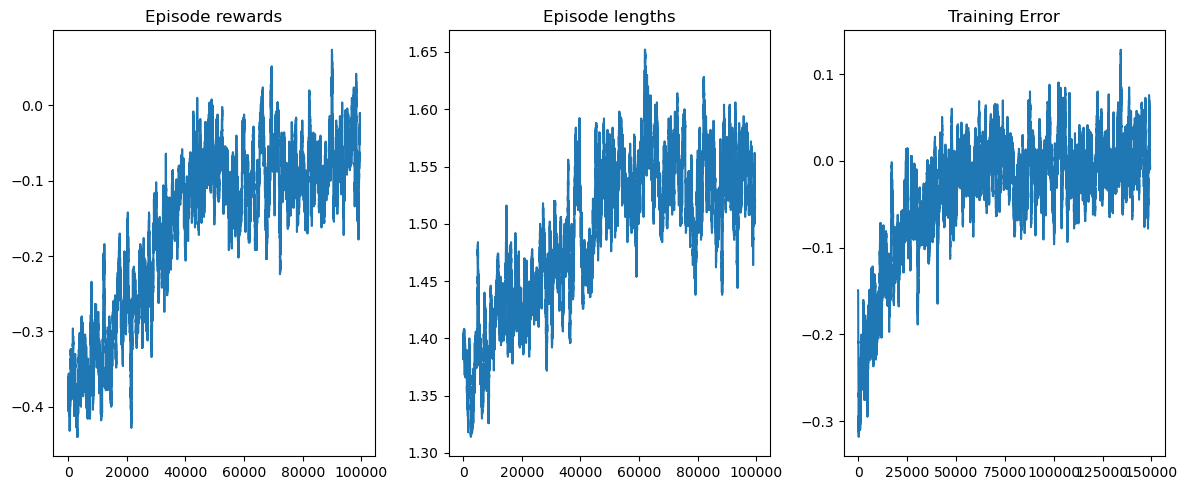

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [6]:
# Evaluating

test_n_episodes = 100_000
wins = 0
losses = 0
draws = 0


for episode in tqdm(range(test_n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs, mode="test")
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        obs = next_obs

    if reward == 1:
        wins += 1
    elif reward == -1:
        losses += 1
    else:
        draws += 1

win_rate = wins / test_n_episodes * 100
loss_rate = losses / test_n_episodes * 100
draw_rate = draws / test_n_episodes * 100


print(f"Win Rate:  {win_rate:.2f}%")
print(f"Loss Rate: {loss_rate:.2f}%")
print(f"Draw Rate: {draw_rate:.2f}%")

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 24050.98it/s]

Win Rate:  % 42.33
Loss Rate: % 48.30
Draw Rate: % 9.37
